In [20]:
import sys
import re
import numpy as np
import pandas as pd

from numpy import dot
from numpy.linalg import norm

from operator import add
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, explode, col, desc
import matplotlib.pyplot as plt

from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator

from datetime import datetime

In [7]:
sc = SparkContext()

In [21]:
spark = SparkSession(sc)

In [9]:
#To extract genres from the genre column
def genre(arr):
    arr = arr.replace(']"', '').split(', {')
    for i in range(len(arr)):
        arr[i] = arr[i][arr[i].index('""name') + 12:arr[i].index('""}')]
    return arr

def isfloat(value):
        try:
            float(value)
            return True
        except:
            return False

def correctRows(p):
    if (len(p) == 20):
        if (isfloat(p[0]) and isfloat(p[8]) and isfloat(p[12]) and isfloat(p[13]) and isfloat(p[18])):
            if (float(p[0])>0 and float(p[8])>0 and float(p[12])>0 and float(p[13])>0 and float(p[18])>0):
                if (len(p[1])>2 and len(p[9])>2):
                    return p

In [10]:
tmdb_movies = sc.textFile('tmdb_5000_movies.csv')
#tmdb_movies = sc.textFile(sys.argv[1], 1)

#Remove header and split data
header = tmdb_movies.first()
#Split by , followed by non-whitespace
regex = re.compile(',(?=\\S)')
tmdb_movies = tmdb_movies.filter(lambda x: x != header).map(lambda x: regex.split(x))

print('Number of rows before cleaning: ', tmdb_movies.count())

#Filter rows based on data type and value
tmdb_movies_filtered = tmdb_movies.filter(correctRows)

#Only keep used columns (title(x[6]), Budget (x[0]), Genre(x[1]), Popularity(x[8]),
#                        Release Date(x[11]), Revenue(x[12]), 
#                        Profit(x[12]-x[0]), Runtime(x[13]), Average Rating(x[18]))
tmdb_movies_filtered = tmdb_movies_filtered.map(lambda x: (x[6], float(x[0]), genre(x[1]), float(x[8]),  
                                                           datetime.strptime(x[11], '%Y-%m-%d'),
                                                           float(x[12]), float(x[12])-float(x[0]), 
                                                           float(x[13]), float(x[18])))

#Remove movies with profit <= 0
tmdb_movies_filtered = tmdb_movies_filtered.filter(lambda x: x[6] > 0)

print('Number of rows after cleaning: ', tmdb_movies_filtered.count())

# Updated Columns:
# title(x[0])
# Budget (x[1])
# Genre(x[2])
# Popularity(x[3])
# Release Date(x[4])
# Revenue(x[5])
# Profit (x[6])
# Runtime(x[7])
# Average Rating(x[8])

Number of rows before cleaning:  4806
Number of rows after cleaning:  2353


## Top 10 Most Profitable Movie Titles

Titles sorted based on Profit: [('Avatar', 2550965087.0), ('Titanic', 1645034188.0), ('Jurassic World', 1363528810.0), ('Furious 7', 1316249360.0), ('The Avengers', 1299557910.0), ('Avengers: Age of Ultron', 1125403694.0), ('Frozen', 1124219009.0), ('Minions', 1082730962.0), ('The Lord of the Rings: The Return of the King', 1024888979.0), ('Iron Man 3', 1015439994.0), ('Transformers: Dark of the Moon', 928746996.0), ('Skyfall', 908561013.0), ('Captain America: Civil War', 903304495.0), ('Despicable Me 2', 894761885.0), ('Toy Story 3', 866969703.0), ("Pirates of the Caribbean: Dead Man's Chest", 865659812.0), ('Jurassic Park', 857100000.0), ("Harry Potter and the Philosopher's Stone", 851475550.0), ('The Lord of the Rings: The Two Towers', 847287400.0), ('Finding Nemo', 846335536.0)]


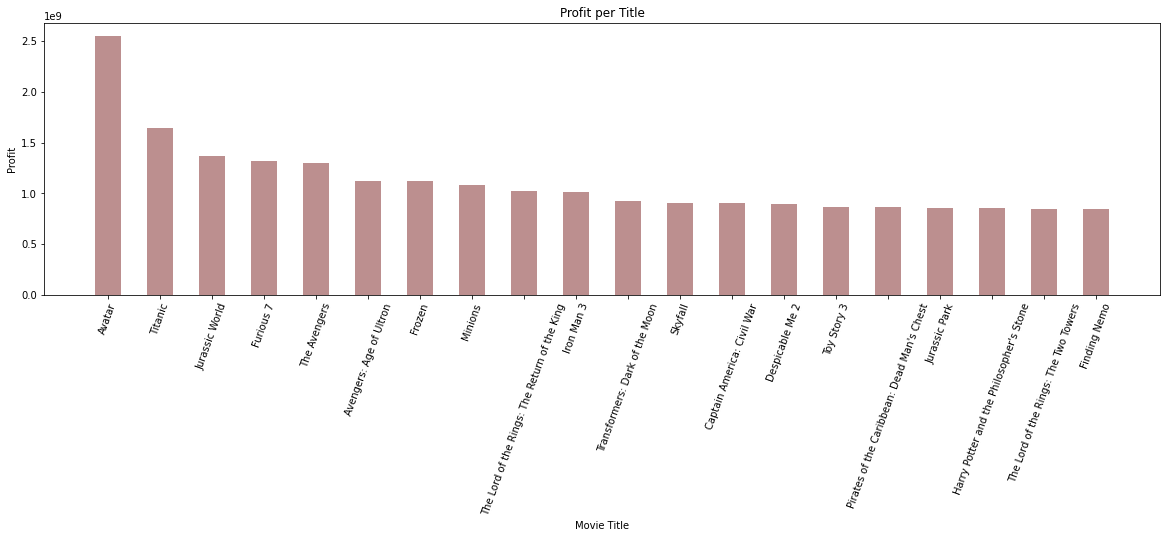

In [11]:
profit_title = tmdb_movies_filtered.map(lambda x: (x[0], x[6])).\
                                    reduceByKey(add)
profit_title_top = profit_title.top(20, lambda x: x[1])
print('Titles sorted based on Profit:', profit_title_top)

x = [i[0] for i in profit_title_top]
y = [i[1] for i in profit_title_top]

fig = plt.figure(figsize = (20, 5)) 

plt.bar(x, y, color ='rosybrown', width = 0.5) 
  
plt.xlabel("Movie Title") 
plt.xticks(rotation=70)
plt.ylabel("Profit") 
plt.title("Profit per Title") 
plt.show() 

## Average Rating per Genre

Genres sorted based on Average Rating: [('War', 7.04), ('History', 6.92), ('Western', 6.89), ('Drama', 6.76), ('Documentary', 6.72), ('Music', 6.6), ('Crime', 6.59), ('Animation', 6.55), ('Mystery', 6.51), ('Romance', 6.46), ('Adventure', 6.35), ('Thriller', 6.33), ('Action', 6.29), ('Fantasy', 6.28), ('Science Fiction', 6.28), ('Family', 6.28), ('Comedy', 6.21), ('Horror', 5.98)]


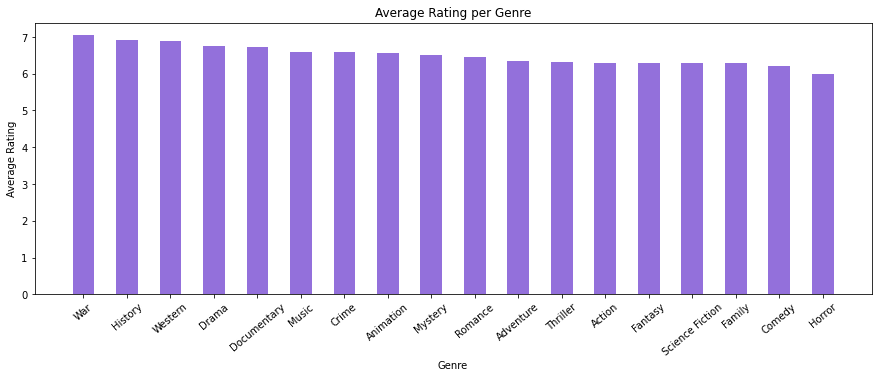

In [12]:
avgRating_genre = tmdb_movies_filtered.map(lambda x: (x[8], x[2])).flatMapValues(lambda x: x).\
                    map(lambda x: (x[1], (x[0], 1))).\
                    reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])).\
                    map(lambda x: (x[0], round(x[1][0]/x[1][1],2)))
avgRating_genre_top = avgRating_genre.top(20, lambda x: x[1])
print('Genres sorted based on Average Rating:', avgRating_genre_top)

x = [i[0] for i in avgRating_genre_top]
y = [i[1] for i in avgRating_genre_top]

fig = plt.figure(figsize = (15, 5)) 

plt.bar(x, y, color ='mediumpurple', width = 0.5) 
  
plt.xlabel("Genre") 
plt.xticks(rotation=40)
plt.ylabel("Average Rating") 
plt.title("Average Rating per Genre") 
plt.show() 

## Average Profit per Genre

Genres sorted based on Average Profit: [('Animation', 257164871.63), ('Adventure', 222571625.18), ('Fantasy', 207561588.06), ('Family', 197749574.76), ('Science Fiction', 170339696.76), ('Action', 159661300.06), ('Comedy', 100522552.0), ('Thriller', 99005509.89), ('Mystery', 93778804.91), ('Romance', 88946257.0), ('War', 88629384.7), ('Drama', 79149724.7), ('Crime', 76971913.24), ('Music', 75165538.22), ('History', 65530643.99), ('Horror', 60514096.11), ('Western', 55624221.79), ('Documentary', 36443490.68)]


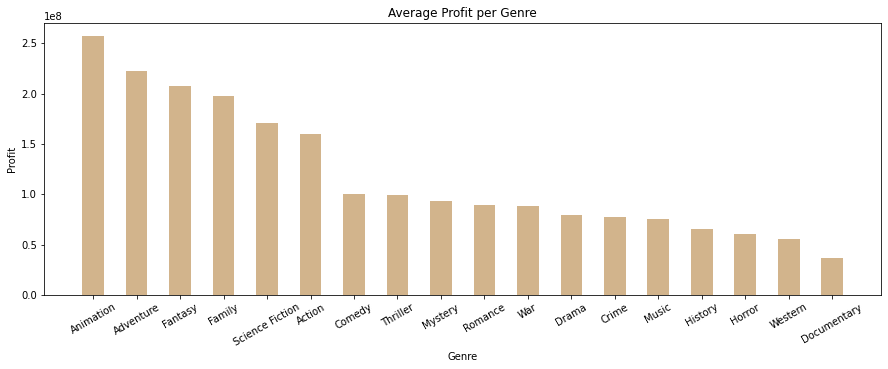

In [14]:
profit_genre = tmdb_movies_filtered.map(lambda x: (x[6], x[2])).flatMapValues(lambda x: x).\
                    map(lambda x: (x[1], (x[0], 1))).\
                    reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])).\
                    map(lambda x: (x[0], round(x[1][0]/x[1][1],2)))
profit_genre_top = profit_genre.top(20, lambda x: x[1])
print('Genres sorted based on Average Profit:', profit_genre_top)

x = [i[0] for i in profit_genre_top]
y = [i[1] for i in profit_genre_top]

fig = plt.figure(figsize = (15, 5)) 

plt.bar(x, y, color ='tan', width = 0.5) 
  
plt.xlabel("Genre") 
plt.xticks(rotation=30)
plt.ylabel("Profit") 
plt.title("Average Profit per Genre") 
plt.show() 

## Budget vs Profit per Genre

[Text(0.2, 0, 'Animation'),
 Text(1.2, 0, 'Adventure'),
 Text(2.2, 0, 'Fantasy'),
 Text(3.2, 0, 'Family'),
 Text(4.2, 0, 'Science Fiction'),
 Text(5.2, 0, 'Action'),
 Text(6.2, 0, 'Comedy'),
 Text(7.2, 0, 'Thriller'),
 Text(8.2, 0, 'Mystery'),
 Text(9.2, 0, 'Romance'),
 Text(10.2, 0, 'War'),
 Text(11.2, 0, 'Drama'),
 Text(12.2, 0, 'Crime'),
 Text(13.2, 0, 'Music'),
 Text(14.2, 0, 'History'),
 Text(15.2, 0, 'Horror'),
 Text(16.2, 0, 'Western'),
 Text(17.2, 0, 'Documentary')]

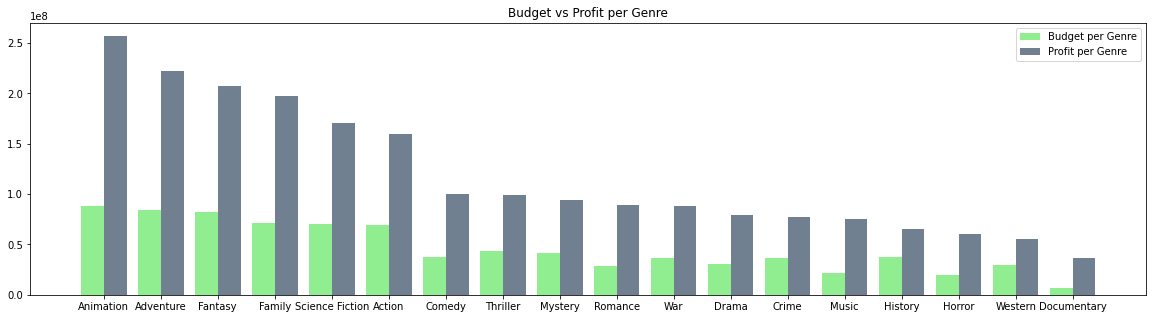

In [15]:
budget_genre = tmdb_movies_filtered.map(lambda x: (x[1], x[2])).flatMapValues(lambda x: x).\
                    map(lambda x: (x[1], (x[0], 1))).\
                    reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])).\
                    map(lambda x: (x[0], round(x[1][0]/x[1][1],2)))
budget_genre = budget_genre.top(20)

profit_genre = tmdb_movies_filtered.map(lambda x: (x[6], x[2])).flatMapValues(lambda x: x).\
                    map(lambda x: (x[1], (x[0], 1))).\
                    reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])).\
                    map(lambda x: (x[0], round(x[1][0]/x[1][1],2)))
profit_genre = profit_genre.top(20)

x = [i[0] for i in profit_genre]
y1 = [i[1] for i in budget_genre]
y2 = [i[1] for i in profit_genre]

df = pd.DataFrame({'Genre': x, 'Budget': y1, 'Profit': y2}, index = x).sort_values(
                                                                    by = 'Profit', ascending=False)

fig, ax = plt.subplots(figsize=(20, 5))
position = np.arange(len(x))

budget = ax.bar(position, df['Budget'], width = 0.4, color = 'lightgreen')
# Same thing, but offset the x by the width of the bar.
profit = ax.bar(position + 0.4, df['Profit'], width=0.4, color = 'slategrey')

plt.legend(('Budget per Genre','Profit per Genre'))  
plt.title("Budget vs Profit per Genre") 
ax.set_xticks(position + 0.4 / 2)
ax.set_xticklabels(df['Genre'])

## Profit per Release Month 

Months sorted based on Average Profit: [(6, 178451445.5), (5, 177283121.15), (11, 151840483.06), (12, 133322008.28), (7, 128298959.91), (4, 109459095.54), (3, 93569751.45), (10, 82812576.47), (8, 73045425.82), (2, 72125126.73), (9, 61482542.02), (1, 51698846.07)]


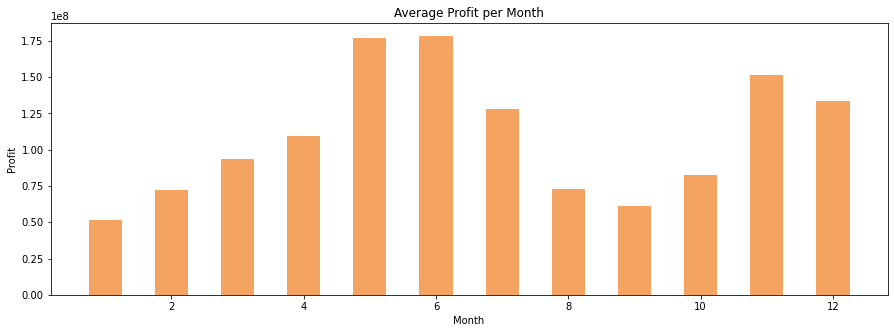

In [16]:
profit_month = tmdb_movies_filtered.map(lambda x: (x[4].month, (x[6], 1))).\
                                    reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])).\
                                    map(lambda x: (x[0], round(x[1][0]/x[1][1],2)))
profit_month_top = profit_month.top(12, lambda x: x[1])
print('Months sorted based on Average Profit:', profit_month_top)

x = [i[0] for i in profit_month_top]
y = [i[1] for i in profit_month_top]

fig = plt.figure(figsize = (15, 5)) 

plt.bar(x, y, color ='sandybrown', width = 0.5) 
  
plt.xlabel("Month") 
plt.ylabel("Profit") 
plt.title("Average Profit per Month") 
plt.show() 

## Linear Regression to Predict Profit (Revenue - Budget):

Prediction is based on Budget, Genre, Popularity, Release Month and Runtime

In [22]:
print("Linear Regression started at: ", datetime.now().strftime("%H:%M:%S"))

#Since Genre is categorical, StringIndexer will be used to map each category to a corresponding 
#numerical value
#To use StringIndexer, we will need to conver to DF first
linear_profitDF = tmdb_movies_filtered.map(lambda x: (x[6], x[1], x[2], x[3], x[4].month, x[7])).\
                                        toDF(['label', 'Budget', 'Genre', 'Population', 
                                             'ReleaseMonth', 'Runtime'])
linear_profitDF = linear_profitDF.select('label', 'Budget', explode('Genre'), 'Population', 
                                         'ReleaseMonth', 'Runtime')

#Create StringIndexer instance
genreIndexer = StringIndexer(inputCol="col", outputCol="Genre")

#Fit the indexer and transform to generate the new DF 
linear_profitDF = genreIndexer.fit(linear_profitDF).transform(linear_profitDF).drop('col')

#Use VectorAssembler to assemble all features into one column
vecAssembler = VectorAssembler().setInputCols(['Budget', 'Genre', 'Population', 'ReleaseMonth', 
                                            'Runtime']).setOutputCol('features')
linear_profitDF = vecAssembler.transform(linear_profitDF).select('label', 'features')

#Split data into train and test (40/60)
linearTrainDF, linearTestDF = linear_profitDF.randomSplit([0.4, 0.6], seed=123)

#Create the model instance
lr = LinearRegression(featuresCol='features', labelCol='label', predictionCol='prediction')

#We use a ParamGridBuilder to construct a grid of parameters to search over.
#(This is from https://spark.apache.org/docs/latest/ml-tuning.html)
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01, 0.001, 0.0001]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

#CrossValidation with k = 3 folds for hyperparameter tuning: it will try all combinations of values 
#and computes the average evaluation metric for the 3 Models produced by fitting the Estimator on 
#the 3 different (training, test) dataset pairs 
#(This is from https://spark.apache.org/docs/latest/ml-tuning.html)
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

#Fitting the training data
model = crossval.fit(linearTrainDF)

#Testing the model
ytest_ypred = model.transform(linearTestDF)

#Evaluating the model using testing result
linearEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2")
print("R Squared (r2): ", round(linearEvaluator.evaluate(ytest_ypred), 2)*100, '%')

#This means the model can explain 48% of variability in Profit

print("Linear Regression ended at: ", datetime.now().strftime("%H:%M:%S"))

Linear Regression started at:  18:29:14
R Squared (r2):  48.0 %
Linear Regression ended at:  18:29:57


## Logistic Regression to Evaluate Movie Success:

- 1 (Successful): If Average Rating is >= 6.0
- 0 (Unsuccessful): If Average Rating is < 6.0
---------
Prediction is based on Budget, Popularity and Runtime

Logistic Regression without using Weights (Unbalanced)

In [23]:
print("Unbalanced Logistic Regression started at: ", datetime.now().strftime("%H:%M:%S"))

#Budget x[1], popularity x[3] and runtime x[7]
logit_success = tmdb_movies_filtered.map(lambda x: (1 if x[8] >= 6 else 0, [x[1], x[3], x[7]]))

#Check if data is balanced/unbalanced
print("Number of 1's vs 0's:", 
     (logit_success.filter(lambda x: x[0] == 1).count(), logit_success.filter(lambda x: x[0] == 0).count()))

#Split data into train and test (40/60)
logitTrain, logitTest = logit_success.randomSplit([0.4, 0.6], seed=123)

#Load and parse the data
def parsePoint(line):
    return LabeledPoint(line[0], line[1])
logitTrainParsed = logitTrain.map(parsePoint)

# Build the model
model = LogisticRegressionWithLBFGS.train(logitTrainParsed)

logitTestParsed = logitTest.map(parsePoint)

ytest_ypred = logitTestParsed.map(lambda x: (float(model.predict(x.features)), x.label))

metrics = BinaryClassificationMetrics(ytest_ypred)

print("Area under ROC = ", round(metrics.areaUnderROC*100, 2), '%')
print("Unbalanced Logistic Regression ended at: ", datetime.now().strftime("%H:%M:%S"))

Unbalanced Logistic Regression started at:  18:30:21
Number of 1's vs 0's: (1712, 641)
Area under ROC =  50.54 %
Unbalanced Logistic Regression ended at:  18:30:24


Logistic Regression with Weights (Resolves the issue with unbalanced data) and hyperparameter tuning

*DF Logistic Regression is used here instead of RDD because working with weights is much simpler in DF compared to RDD

In [24]:
print("Weighted Logistic Regression started at: ", datetime.now().strftime("%H:%M:%S"))

#Convert to DF 
logit_successDF = tmdb_movies_filtered.map(lambda x: (1.0 if x[8] >= 6 else 0.0, x[1], x[3], x[7]))\
                                        .toDF(['label', 'Budget', 'Population', 'Runtime'])

#Use VectorAssembler to assemble all features into one column
vecAssembler = VectorAssembler().setInputCols(['Budget', 'Population', 'Runtime']).\
                                setOutputCol('features')
logit_successDF = vecAssembler.transform(logit_successDF).select('label', 'features')

#Split data into train and test (40/60)
logitTrainDF, logitTestDF = logit_successDF.randomSplit([0.4, 0.6], seed=123)

#Since there are more 1's than 0's (1712, 641) then they will be used as balancing weight
weight = logitTrainDF.select('label').where('label == 1').count() / logitTrainDF.count()

#Then weights column is added where the balancing (higher) weight is assigned for the minority class (0)
logitTrainDF = logitTrainDF.withColumn('weights', when(logitTrainDF['label'] == 0, weight)\
                                       .otherwise(1-weight))

#Create the model instance
lr = LogisticRegression(labelCol = 'label', featuresCol = 'features', weightCol = 'weights')

#We use a ParamGridBuilder to construct a grid of parameters to search over.
#(This is from https://spark.apache.org/docs/latest/ml-tuning.html)
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01, 0.001, 0.0001]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .addGrid(lr.standardization, [False, True])\
    .build()

#CrossValidation with k = 3 folds for hyperparameter tuning: it will try all combinations of values 
#and computes the average evaluation metric for the 3 Models produced by fitting the Estimator on 
#the 3 different (training, test) dataset pairs 
#(This is from https://spark.apache.org/docs/latest/ml-tuning.html)
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

#Fitting the training data
model = crossval.fit(logitTrainDF)

#Testing the model
ytest_ypred_weighted = model.transform(logitTestDF)

#Evaluating the model
ytest_ypred_weighted = ytest_ypred_weighted.select('label', 'prediction').rdd.map(tuple)

metrics = BinaryClassificationMetrics(ytest_ypred_weighted)

print("Area under ROC = ", round(metrics.areaUnderROC*100, 2), '%')
print("Weighted Logistic Regression ended at: ", datetime.now().strftime("%H:%M:%S"))

sc.stop()



Weighted Logistic Regression started at:  18:30:40
Area under ROC =  67.82 %
Weighted Logistic Regression ended at:  18:36:08
